![image.png](https://towardsdatascience.com/wp-content/uploads/2024/05/1Qww2aaIdqrWVeNmo3AS0ZQ-2048x1314.png)




# BERT (encoder-only)

BERT is an "encoder-only" [transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model) "Transformer (machine learning model)") architecture. At a high level, BERT consists of 4 modules:

-   Tokenizer: This module converts a piece of English text into a sequence of integers ("tokens").
-   [Embedding](https://en.wikipedia.org/wiki/Word_embedding "Word embedding"): This module converts the sequence of tokens into an array of real-valued vectors representing the tokens. It represents the conversion of discrete token types into a lower-dimensional [Euclidean space](https://en.wikipedia.org/wiki/Euclidean_space "Euclidean space").
-   Encoder: a stack of Transformer blocks with [self-attention](https://en.wikipedia.org/wiki/Attention_(machine_learning) "Attention (machine learning)"), but without causal masking.
-   Task head: This module converts the final representation vectors into one-hot encoded tokens again by producing a predicted probability distribution over the token types. It can be viewed as a simple decoder, decoding the latent representation into token types, or as an "un-embedding layer".

The task head is necessary for pre-training, but it is often unnecessary for so-called "downstream tasks," such as [question answering](https://en.wikipedia.org/wiki/Question_answering "Question answering") or [sentiment classification](https://en.wikipedia.org/wiki/Sentiment_analysis "Sentiment analysis"). Instead, one removes the task head and replaces it with a newly initialized module suited for the task, and finetune the new module. The latent vector representation of the model is directly fed into this new module, allowing for sample-efficient [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning "Transfer learning").

## Libraries

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import math
import random

## Spectral Curvature

###### Load Model

In [ ]:
MODEL_NAME = "bert-large-uncased"

PROMPT1 = "The artist drew a landscape with a river flowing towards the mountains." # Plain English
PROMPT2 = "इसे आज़माने के लिए, नीचे अपनी भाषा और इनपुट उपकरण चुनें और लिखना आरंभ करें|" # Hindi
PROMPT3 = '''**The CS- Inequality**\$$\left( \sum_{k=1}^n a_k b_k \right)^2 \leq \left( \sum_{k=1}^n
a_k^2 \right) \left( \sum_{k=1}^n b_k^2 \right)$$''' #Math Jargon
PROMPT4 = "श्वः अतीव द्रुतं धावति" #Sanskrit
PROMPT6 = '''Z = \int \mathcal{D}\phi \, \exp \left( i \int d^4x \, \sqrt{-g(x)}
\left[ \frac{1}{2} g^{\mu\nu}(x) \partial_\mu \phi(x) \, \partial_\nu \phi(x)
- \frac{1}{2} m^2 \phi^2(x)
- \frac{\lambda}{4!} \phi^4(x)
+ \frac{1}{16\pi G} (R(x) - 2\Lambda) \right] \right)''' #Math jargon 2


PROMPT = PROMPT6

print(f"Loading model: {MODEL_NAME}...") # Load the Tokenizer, Model

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

model.eval() # Set the model to evaluation mode
print("Model loaded successfully.")

<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:8: SyntaxWarning: invalid escape sequence '\i'
<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:8: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-2131410676.py:5: SyntaxWarning: invalid escape sequence '\$'
  PROMPT3 = "**The Cauchy-Schwarz Inequality**\$$\left( \sum_{k=1}^n a_k b_k \right)^2 \leq \left( \sum_{k=1}^n a_k^2 \right) \left( \sum_{k=1}^n b_k^2 \right)$$" #nput prompt3
/tmp/ipython-input-2131410676.py:8: SyntaxWarning: invalid escape sequence '\i'
  PROMPT6 = '''Z = \int \mathcal{D}\phi \, \exp \left( i \int d^4x \, \sqrt{-g(x)}


Loading model: bert-large-uncased...
Model loaded successfully.


In [ ]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

In [ ]:
model.encoder.layer

ModuleList(
  (0-23): 24 x BertLayer(
    (attention): BertAttention(
      (self): BertSdpaSelfAttention(
        (query): Linear(in_features=1024, out_features=1024, bias=True)
        (key): Linear(in_features=1024, out_features=1024, bias=True)
        (value): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (output): BertSelfOutput(
        (dense): Linear(in_features=1024, out_features=1024, bias=True)
        (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (intermediate): BertIntermediate(
      (dense): Linear(in_features=1024, out_features=4096, bias=True)
      (intermediate_act_fn): GELUActivation()
    )
    (output): BertOutput(
      (dense): Linear(in_features=4096, out_features=1024, bias=True)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
  

###### Place Hooks

In [ ]:
# Capture Activations

captured_activations = [] # Store the output (hidden state) of each layer.

def get_activation_hook():
    """
    Returns a hook function that can be attached to a PyTorch module.
    The hook will append the module's output to our `captured_activations` list.
    """
    def hook(module, input, output):
        captured_activations.append(output[0].detach().cpu())
    return hook

# Get the list of transformer layers
target_layers = model.encoder.layer

# Register our hook on each layer
for layer in target_layers:
    layer.register_forward_hook(get_activation_hook())

print(f"Registered hooks on {len(target_layers)} layers.")

Registered hooks on 24 layers.


###### Calculate Spectral Curvature, $ ∀ $ layers $ l $ :

$$ K_l = || K_{l+1} - 2K_l + K_{l-1}||_{frobenius}$$





In [ ]:
# Forward Pass
inputs = tokenizer(PROMPT, return_tensors="pt")
print("Running forward pass to capture activations...")
with torch.no_grad():
    outputs = model(**inputs)

print(f"Successfully captured {len(captured_activations)} hidden states.")

Running forward pass to capture activations...
Successfully captured 24 hidden states.


In [ ]:
# check:
inspec = []
i = 10
h_prev = captured_activations[i-1]
h_curr = captured_activations[i]
h_next = captured_activations[i+1]

print("3 activations:", h_prev, h_curr, h_next)
print ("---------------------------------------------------------------------------------------------")

bending_vector = h_next - 2 * h_curr + h_prev
print(bending_vector)
print ("---------------------------------------------------------------------------------------------")

curvature = torch.linalg.norm(bending_vector).item()
inspec.append(curvature)
print(inspec)

3 activations: tensor([[[-0.1738, -0.0967, -1.0453,  ..., -0.3006, -0.3920,  0.5932],
         [-0.4908, -0.7233,  0.7674,  ..., -0.2477,  0.6125,  0.1601],
         [-1.4448,  0.7804,  0.6184,  ...,  1.1896,  1.1774, -0.2939],
         ...,
         [-1.0388, -0.3448,  1.4964,  ...,  0.6862,  0.1894,  0.6569],
         [-0.0019,  0.1290, -0.3617,  ...,  0.5059,  0.0545, -0.2054],
         [ 0.0217,  0.0345, -0.1259,  ..., -0.0214,  0.0652, -0.0146]]]) tensor([[[-0.2474, -0.1016, -1.5624,  ..., -0.2758, -0.8255,  0.6348],
         [-0.4881, -0.3301,  0.3491,  ...,  0.1391,  0.2589, -0.1933],
         [-1.6315,  0.7019,  0.8759,  ...,  0.9238,  1.0922, -0.7107],
         ...,
         [-1.6392, -0.1929,  0.8638,  ...,  0.6532,  0.1204,  0.2716],
         [ 0.0034,  0.0517, -1.0286,  ...,  0.7216,  0.0107, -0.7652],
         [ 0.0474, -0.0388, -0.1048,  ..., -0.0123, -0.0835,  0.0316]]]) tensor([[[-0.1253, -0.2554, -1.2662,  ..., -0.1123, -0.8046,  0.6351],
         [-0.7564,  0.0054,  0

In [ ]:
# Calculate the Spectral Curvature
spectral_curvatures = []
print("Calculating spectral curvature...")
for i in range(1, len(captured_activations) - 1):
    h_prev = captured_activations[i-1]
    h_curr = captured_activations[i]
    h_next = captured_activations[i+1]

    bending_vector = h_next - 2 * h_curr + h_prev

    # Calculate its magnitude using the Frobenius norm to get a single scalar value.
    curvature = torch.linalg.norm(bending_vector).item()
    spectral_curvatures.append(curvature)

# Print the raw curvature values for inspection
for i, curve in enumerate(spectral_curvatures):
    # The layer number is i+1 because our loop starts its calculation at the 2nd layer.
    print(f"  - Curvature at Layer {i + 1}: {curve:.4f}")

Calculating spectral curvature...
  - Curvature at Layer 1: 138.4928
  - Curvature at Layer 2: 121.9096
  - Curvature at Layer 3: 108.8429
  - Curvature at Layer 4: 123.1918
  - Curvature at Layer 5: 153.9402
  - Curvature at Layer 6: 181.6430
  - Curvature at Layer 7: 161.3245
  - Curvature at Layer 8: 163.4683
  - Curvature at Layer 9: 160.7339
  - Curvature at Layer 10: 176.5997
  - Curvature at Layer 11: 168.8460
  - Curvature at Layer 12: 162.5035
  - Curvature at Layer 13: 170.4438
  - Curvature at Layer 14: 191.1957
  - Curvature at Layer 15: 157.4857
  - Curvature at Layer 16: 145.7744
  - Curvature at Layer 17: 137.9570
  - Curvature at Layer 18: 131.8754
  - Curvature at Layer 19: 164.8761
  - Curvature at Layer 20: 153.4233
  - Curvature at Layer 21: 129.0575
  - Curvature at Layer 22: 256.1677


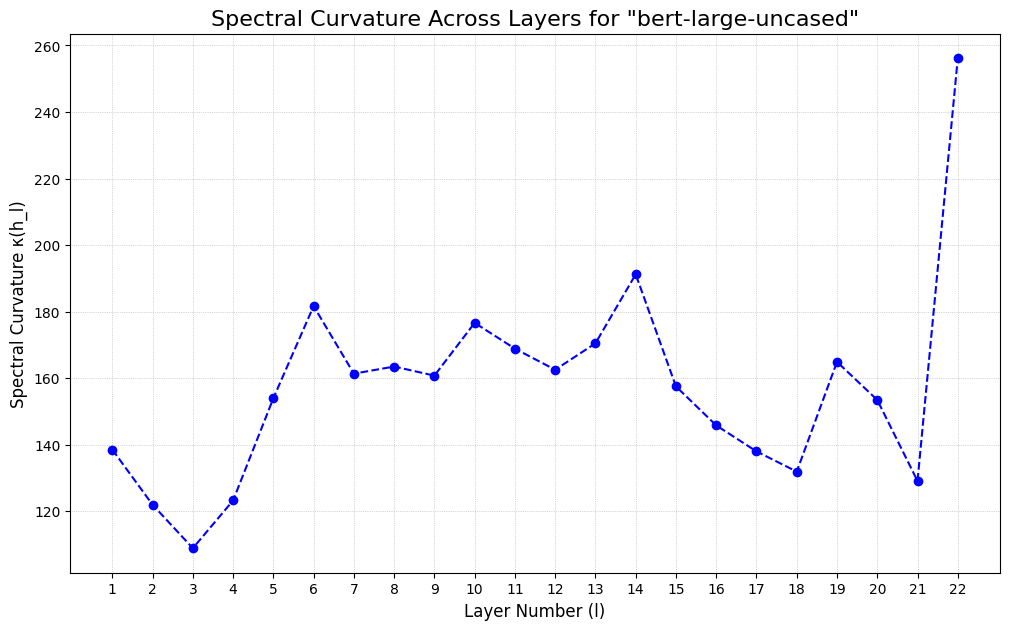

In [ ]:
layer_indices = range(1, len(spectral_curvatures) + 1)

plt.figure(figsize=(12, 7))
plt.plot(layer_indices, spectral_curvatures, marker='o', linestyle='--', color='b')
plt.title(f'Spectral Curvature Across Layers for "{MODEL_NAME}"', fontsize=16)
plt.xlabel('Layer Number (l)', fontsize=12)
plt.ylabel('Spectral Curvature κ(h_l)', fontsize=12)
plt.xticks(list(layer_indices))
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.show()